In [1]:
import pandas as pd
import gmaps
import gmaps.geojson_geometries
import matplotlib.pyplot as plt
import requests
from matplotlib.cm import magma
from matplotlib.colors import to_hex
from math import exp
from scipy.stats import linregress, levene
from numpy import arange

# NEED TO SET UP API KEY
# Let 'gkey' in config be the Google maps api key

from config import gkey

# Health Centers Across the United States

In [2]:
centers_df = pd.read_csv('Resources/centers.csv')
state_df = pd.read_csv('Resources/centers_bystate.csv', header = None, names = ['State', 'Centers'])

## Centers Heatmap

In [3]:
gmaps.configure(api_key = gkey)

locations = centers_df[['Lat', 'Lon']].drop_duplicates()
fig = gmaps.figure()
num_centers = centers_df.groupby(by = 'Zip').count()['Name']
heat_layer = gmaps.heatmap_layer(locations, weights = num_centers, max_intensity = 85, point_radius = 6)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Centers by State

In [4]:
# this block is to order the states in the weird order that is needed for the state_geojson in the next block, so that they can be colored properly.

url = 'https://s3-eu-west-1.amazonaws.com/jupyter-gmaps-examples/us-states.geo.json'
weird_order = requests.get(url).json()
states_order = []
for i in range(52):
    states_order.append(weird_order['features'][i]['properties']['NAME'])
    
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia' : 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico' : 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

state_order_abbr = []
for state in states_order:
    state_order_abbr.append(us_state_abbrev[state])
    
state_geojson = gmaps.geojson_geometries.load_geometry('us-states')
fig = gmaps.figure()
min_centers = int(min(state_df['Centers']))
max_centers = int(max(state_df['Centers']))
range_centers = max_centers - min_centers

def calculate_color(count):
    normalized = (int(count) - min_centers) / range_centers
    mpl_color = magma(normalized)
    gmaps_color = to_hex(mpl_color, keep_alpha = False)
    return gmaps_color

colors = []

for state in state_order_abbr:
    colors.append(calculate_color(state_df.loc[state_df['State'] == state]['Centers']))

centers_layer = gmaps.geojson_layer(state_geojson, fill_color = colors, stroke_color = colors, fill_opacity = 0.8)
fig.add_layer(centers_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# MHS Region Comparison

In [5]:
mhs = pd.read_csv('Resources/mhs_subset.csv')

In [6]:
# create data frames for each region

mhs_south = mhs.loc[mhs["Region"] == "South", :]
# mhs_south.sample(10)

mhs_northeast = mhs.loc[mhs["Region"] == "Northeast", :]
# mhs_northeast.sample(10)

mhs_midwest = mhs.loc[mhs["Region"] == "Midwest", :]
# mhs_midwest.sample(10)

mhs_west = mhs.loc[mhs["Region"] == "West", :]
# mhs_west.sample(10)

## Suicide Prevention Programs

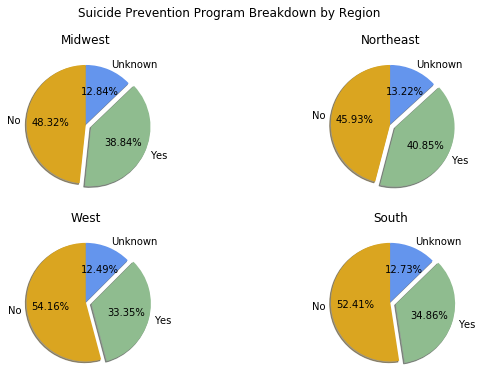

In [7]:
# reduced data frames for each region and grab data from column "MHSuicide"
mhs_w_suicide = mhs_west[["MHSuicide", "State"]]
suicide_prev_w = mhs_w_suicide["MHSuicide"].value_counts()

mhs_mw_suicide = mhs_midwest[["MHSuicide", "State"]]
suicide_prev_mw = mhs_mw_suicide["MHSuicide"].value_counts()

mhs_ne_suicide = mhs_northeast[["MHSuicide", "State"]]
suicide_prev_ne = mhs_ne_suicide["MHSuicide"].value_counts()

mhs_s_suicide = mhs_south[["MHSuicide", "State"]]
suicide_prev_s = mhs_s_suicide["MHSuicide"].value_counts()

# set up pie charts for each region as subplots on one figure
labels = mhs["MHSuicide"].unique()
explode = (0,0.1,0)
colors = ["goldenrod", "darkseagreen", "cornflowerblue"]

# midwest pie chart
plt.figure(figsize = (10,6))
plt.subplot(221)
plt.pie(suicide_prev_mw, explode=explode, labels=labels, colors=colors, autopct="%1.2f%%", 
       shadow=True, startangle=90)
plt.title("Midwest")

# northeast pie chart
plt.subplot(222)
plt.pie(suicide_prev_ne, explode=explode, labels=labels, colors=colors, autopct="%1.2f%%", 
       shadow=True, startangle=90)
plt.title("Northeast")

# west pie chart
plt.subplot(223)
plt.pie(suicide_prev_w, explode=explode, labels=labels, colors=colors, autopct="%1.2f%%", 
       shadow=True, startangle=90)
plt.title("West")

# south pie chart
plt.subplot(224)
plt.pie(suicide_prev_s, explode=explode, labels=labels, colors=colors, autopct="%1.2f%%", 
       shadow=True, startangle=90)
plt.title("South")

# set up title for overall figure, save to file, and display
plt.suptitle("Suicide Prevention Program Breakdown by Region")

plt.savefig("output/SuicidePreventionServices_Regions.png")
plt.show()

## Ownership Type of Mental Health Service Providers

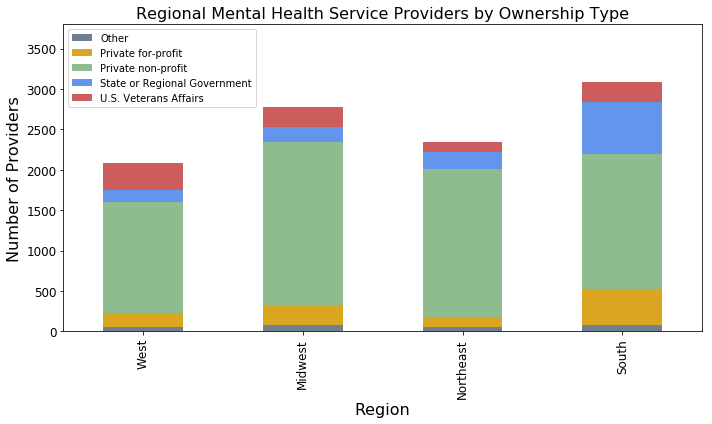

In [8]:
# set up data to use in bar chart
type_west = mhs_west["Ownership"].value_counts()

type_midwest = mhs_midwest["Ownership"].value_counts()

type_northeast = mhs_northeast["Ownership"].value_counts()

type_south = mhs_south["Ownership"].value_counts()

types_all = pd.DataFrame({"West":type_west, "Midwest":type_midwest, "Northeast": type_northeast, 
                               "South": type_south}).T

# create bar chart
types_all.plot(kind="bar", figsize=(10,6), stacked=True, color=("slategrey", "goldenrod", 
                                                                "darkseagreen", "cornflowerblue", 
                                                                "indianred"
                                                                ))
plt.title("Regional Mental Health Service Providers by Ownership Type", fontsize = 16)
plt.xlabel("Region", fontsize = 16)
plt.ylabel("Number of Providers", fontsize = 16)
plt.ylim(0,3800)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("output/MHS_OwnershipType_Regions.png")
plt.show()

# Regional Suicide Rates

In [9]:
mw_data = "Resources/midwest.csv"
s_data = "Resources/south.csv"
ne_data = "Resources/northeast.csv"
w_data = "Resources/west.csv"

# Read data and store into a data frame for sex
midwest_suicide_df = pd.read_csv(mw_data)
south_suicide_df = pd.read_csv(s_data)
northeast_suicide_df = pd.read_csv(ne_data)
west_suicide_df = pd.read_csv(w_data)

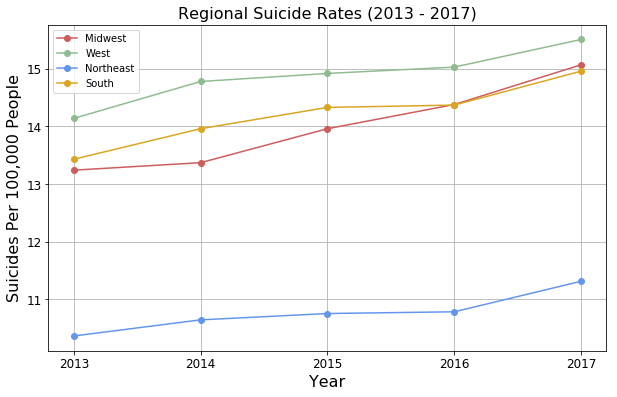

In [10]:
mw_rate = midwest_suicide_df["Crude Rate"]
w_rate = west_suicide_df["Crude Rate"]
s_rate = south_suicide_df["Crude Rate"]
ne_rate = northeast_suicide_df["Crude Rate"]

x = range(5)
years = "2013", "2014", "2015", "2016", "2017"

plt.figure(figsize = (10,6))

plt.plot(years, mw_rate, color="indianred", marker="o", label="Midwest")
plt.plot(years, w_rate, color="darkseagreen", marker="o", label="West")
plt.plot(years, ne_rate, color="cornflowerblue", marker="o", label="Northeast")
plt.plot(years, s_rate, color="goldenrod", marker="o", label="South")
plt.title("Regional Suicide Rates (2013 - 2017)", fontsize = 16)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Suicides Per 100,000 People", fontsize = 16)
plt.legend(loc="best")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.savefig('output/regional_suicide_rates.png')
plt.show()

## Regional Rates by Sex

In [11]:
# Import CSVs
mw_data = "Resources/midwest_sex.csv"
s_data = "Resources/south_sex.csv"
ne_data = "Resources/northeast_sex.csv"
w_data = "Resources/west_sex.csv"

# Read and store CSVs
midwest_suicide_df = pd.read_csv(mw_data)
south_suicide_df = pd.read_csv(s_data)
northeast_suicide_df = pd.read_csv(ne_data)
west_suicide_df = pd.read_csv(w_data)

# Set Male Rates
mw_male_rate = midwest_suicide_df.loc[(midwest_suicide_df["Sex"] == "Males")]
s_male_rate = south_suicide_df.loc[(south_suicide_df["Sex"] == "Males")]
ne_male_rate = northeast_suicide_df.loc[(northeast_suicide_df["Sex"] == "Males")]
w_male_rate = west_suicide_df.loc[(west_suicide_df["Sex"] == "Males")]


# Set Female Rates
mw_female_rate = midwest_suicide_df.loc[(midwest_suicide_df["Sex"] == "Females")]
s_female_rate = south_suicide_df.loc[(south_suicide_df["Sex"] == "Females")]
ne_female_rate = northeast_suicide_df.loc[(northeast_suicide_df["Sex"] == "Females")]
w_female_rate = west_suicide_df.loc[(west_suicide_df["Sex"] == "Females")]

# Set regional rates for males
mw_male = mw_male_rate["Crude Rate"]
w_male = w_male_rate["Crude Rate"]
s_male = s_male_rate["Crude Rate"]
ne_male = ne_male_rate["Crude Rate"]

# Set regional rates for females
mw_female = mw_female_rate["Crude Rate"]
w_female = w_female_rate["Crude Rate"]
s_female = s_female_rate["Crude Rate"]
ne_female = ne_female_rate["Crude Rate"]

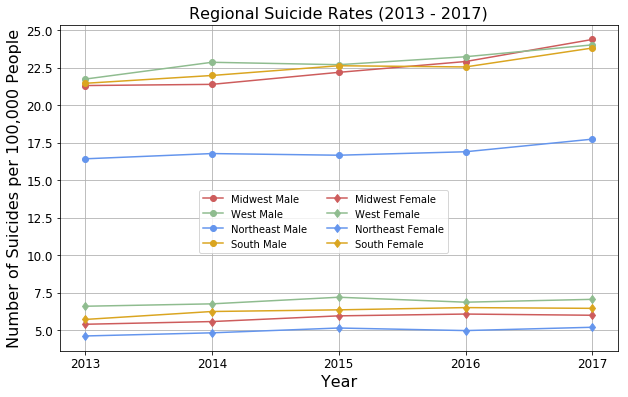

In [12]:
# Set the x axis
x = range(5)
years = "2013", "2014", "2015", "2016", "2017"

plt.figure(figsize = (10,6))

# Plot Males the 4 regions
plt.plot(years, mw_male, color="indianred", marker="o", label="Midwest Male")
plt.plot(years, w_male, color="darkseagreen", marker="o", label="West Male")
plt.plot(years, ne_male, color="cornflowerblue", marker="o", label="Northeast Male")
plt.plot(years, s_male, color="goldenrod", marker="o", label="South Male")

# Plot Females the 4 regions
plt.plot(years, mw_female, color="indianred", marker="d", label="Midwest Female")
plt.plot(years, w_female, color="darkseagreen", marker="d", label="West Female")
plt.plot(years, ne_female, color="cornflowerblue", marker="d", label="Northeast Female")
plt.plot(years, s_female, color="goldenrod", marker="d", label="South Female")

# Label the Chart
plt.title("Regional Suicide Rates (2013 - 2017)", fontsize = 16)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Number of Suicides per 100,000 People", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Show the legend, grid and graph
plt.legend(loc=(.25, .3), ncol=2)
plt.grid()
plt.show()

# National Rates by Sex

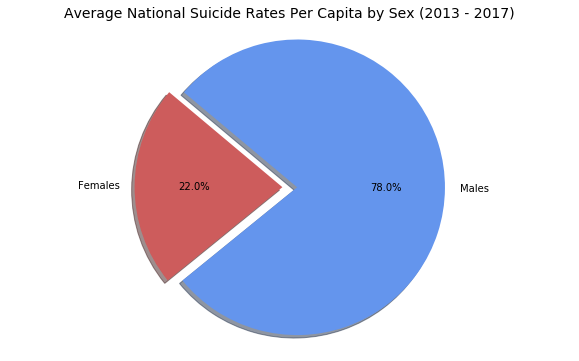

In [13]:
data_file = "Resources/national_suicide_years.csv"

# Read data and store into a data frame for sex
suicide_df = pd.read_csv(data_file)

# Creating a data frame for male rates only
male_suicide_df = suicide_df[(suicide_df ["Sex"] == "Males")]

# Creating a data frame for female rates only
female_suicide_df = suicide_df[(suicide_df ["Sex"] == "Females")]
female_mean = female_suicide_df["Crude Rate"].mean()

gender_rates = suicide_df.groupby(["Sex"]).mean()["Crude Rate"].rename("Gender Rate")

gender_rates_df = pd.DataFrame({"Gender Rate": gender_rates})

labels = ["Females", "Males"]
colors = ["indianred", "cornflowerblue"]
explode = (0.1, 0)

plt.figure(figsize = (10,6))

plt.pie(gender_rates_df, labels = labels, colors = colors, explode=explode, autopct="%1.1f%%", shadow=True, startangle=140)
plt.axis("equal")

plt.title("Average National Suicide Rates Per Capita by Sex (2013 - 2017)", fontsize = 14)

plt.show()

## Suicide Rates and Centers Scatterplot

In [14]:
# Import and read CSVs
df = "Resources/centers_vs_suicide.csv"
states = "Resources/state_census_codes.csv"
income_df = "Resources/income.csv"
add_regions = pd.read_csv(states)
compare_df = pd.read_csv(df)
income = pd.read_csv(income_df)

per_capita = compare_df["Centers"]#/compare_df["Population"]*100000
compare_df["Per Capita"] = per_capita

# Replace state name with state abbreviation in "Suicide" dataframe
add_regions["State"] = add_regions["State"].str.lower()
add_regions["State"] = add_regions["State"].str.title()

add_regions["State"] = add_regions["State"].replace({'Alabama': 'AL',
                                   'Alaska': 'AK',
                                   'Arizona': 'AZ',
                                   'Arkansas': 'AR',
                                   'California': 'CA',
                                   'Colorado': 'CO',
                                   'Connecticut': 'CT',
                                   'Delaware': 'DE',
                                   'Dist_Of_Columbia': 'DC',
                                   'Florida': 'FL',
                                   'Georgia': 'GA',
                                   'Hawaii': 'HI',
                                   'Idaho': 'ID',
                                   'Illinois': 'IL',
                                   'Indiana': 'IN',
                                   'Iowa': 'IA',
                                   'Kansas': 'KS',
                                   'Kentucky': 'KY',
                                   'Louisiana': 'LA',
                                   'Maine': 'ME',
                                   'Maryland': 'MD',
                                   'Massachusetts': 'MA',
                                   'Michigan': 'MI',
                                   'Minnesota': 'MN',
                                   'Mississippi': 'MS',
                                   'Missouri': 'MO',
                                   'Montana': 'MT',
                                   'Nebraska': 'NE',
                                   'Nevada': 'NV',
                                   'New_Hampshire': 'NH',
                                   'New_Jersey': 'NJ',
                                   'New_Mexico': 'NM',
                                   'New_York': 'NY',
                                   'North_Carolina': 'NC',
                                   'North_Dakota': 'ND',
                                   'Ohio': 'OH',
                                   'Oklahoma': 'OK',
                                   'Oregon': 'OR',
                                   'Pennsylvania': 'PA',
                                   'Rhode_Island': 'RI',
                                   'South_Carolina': 'SC',
                                   'South_Dakota': 'SD',
                                   'Tennessee': 'TN',
                                   'Texas': 'TX',
                                   'Utah': 'UT',
                                   'Vermont': 'VT',
                                   'Virginia': 'VA',
                                   'Washington': 'WA',
                                   'West_Virginia': 'WV',
                                   'Wisconsin': 'WI',
                                   'Wyoming': 'WY'})

# Replace state name with state abbreviation in "Suicide" dataframe
income["State"] = income["State"].replace({'Alabama': 'AL',
                                   'Alaska': 'AK',
                                   'Arizona': 'AZ',
                                   'Arkansas': 'AR',
                                   'California': 'CA',
                                   'Colorado': 'CO',
                                   'Connecticut': 'CT',
                                   'Delaware': 'DE',
                                   'District of Columbia': 'DC',
                                   'Florida': 'FL',
                                   'Georgia': 'GA',
                                   'Hawaii': 'HI',
                                   'Idaho': 'ID',
                                   'Illinois': 'IL',
                                   'Indiana': 'IN',
                                   'Iowa': 'IA',
                                   'Kansas': 'KS',
                                   'Kentucky': 'KY',
                                   'Louisiana': 'LA',
                                   'Maine': 'ME',
                                   'Maryland': 'MD',
                                   'Massachusetts': 'MA',
                                   'Michigan': 'MI',
                                   'Minnesota': 'MN',
                                   'Mississippi': 'MS',
                                   'Missouri': 'MO',
                                   'Montana': 'MT',
                                   'Nebraska': 'NE',
                                   'Nevada': 'NV',
                                   'New Hampshire': 'NH',
                                   'New Jersey': 'NJ',
                                   'New Mexico': 'NM',
                                   'New York': 'NY',
                                   'North Carolina': 'NC',
                                   'North Dakota': 'ND',
                                   'Ohio': 'OH',
                                   'Oklahoma': 'OK',
                                   'Oregon': 'OR',
                                   'Pennsylvania': 'PA',
                                   'Rhode Island': 'RI',
                                   'South Carolina': 'SC',
                                   'South Dakota': 'SD',
                                   'Tennessee': 'TN',
                                   'Texas': 'TX',
                                   'Utah': 'UT',
                                   'Vermont': 'VT',
                                   'Virginia': 'VA',
                                   'Washington': 'WA',
                                   'West Virginia': 'WV',
                                   'Wisconsin': 'WI',
                                   'Wyoming': 'WY'})


region_df = pd.merge(compare_df, add_regions, on="State", how = 'left')
regional_income = pd.merge(region_df, income, on="State", how = 'left')
income_region_suicide = regional_income[["State", "Region", "Crude Rate", "Per Capita", "Mean income"]]

In [15]:
region_south = income_region_suicide.loc[income_region_suicide["Region"]== "South"]
region_northeast = income_region_suicide.loc[income_region_suicide["Region"]== "Northeast"]
region_west = income_region_suicide.loc[income_region_suicide["Region"]== "West"]
region_midwest = income_region_suicide.loc[income_region_suicide["Region"]== "Midwest"]

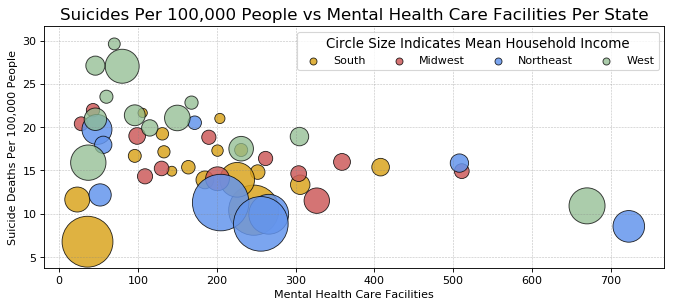

In [16]:
plt.figure(figsize=(10, 4), dpi=80)

plt.scatter(region_south["Per Capita"], region_south["Crude Rate"], marker="o", s=(region_south["Mean income"]/12000).map(exp), color="goldenrod", alpha=.85, linewidth=.75, 
            edgecolors="black", label="South")
plt.scatter(region_midwest["Per Capita"], region_midwest["Crude Rate"], marker="o", s=(region_midwest["Mean income"]/12000).map(exp), color="indianred", alpha=.85, linewidth=.75, 
            edgecolors="black", label="Midwest")
plt.scatter(region_northeast["Per Capita"], region_northeast["Crude Rate"], marker="o", s=(region_northeast["Mean income"]/12000).map(exp), color="cornflowerblue", alpha=.85, linewidth=.75, 
            edgecolors="black", label="Northeast")
plt.scatter(region_west["Per Capita"], region_west["Crude Rate"], marker="o", color="darkseagreen", s=(region_west["Mean income"]/12000).map(exp), alpha=.75, linewidth=.85, 
            edgecolors="black", label="West")

# Size the plot
plot_margin = -2

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 + .25,
          x1 - 3.25,
          y0 - 1.75,
          y1 + .5))

# Label the plot
plt.title("Suicides Per 100,000 People vs Mental Health Care Facilities Per State", horizontalalignment="center", fontsize=15)
plt.xlabel("Mental Health Care Facilities")
plt.ylabel("Suicide Deaths Per 100,000 People")

# Format the grid
plt.grid(color='grey', linestyle='--', linewidth=.5, alpha=.5)
# plt.legend(loc=(.8, .1))
lgnd = plt.legend(loc="best", scatterpoints=1, fontsize=10, ncol=4, title="Circle Size Indicates Mean Household Income", title_fontsize=12)
lgnd.legendHandles[0]._sizes = [40]
lgnd.legendHandles[1]._sizes = [40]
lgnd.legendHandles[2]._sizes = [40]
lgnd.legendHandles[3]._sizes = [40]
# Show the plot
plt.savefig('output/centers_vs_rate_scatter.png')
plt.show()

# Demographics

## Income per State

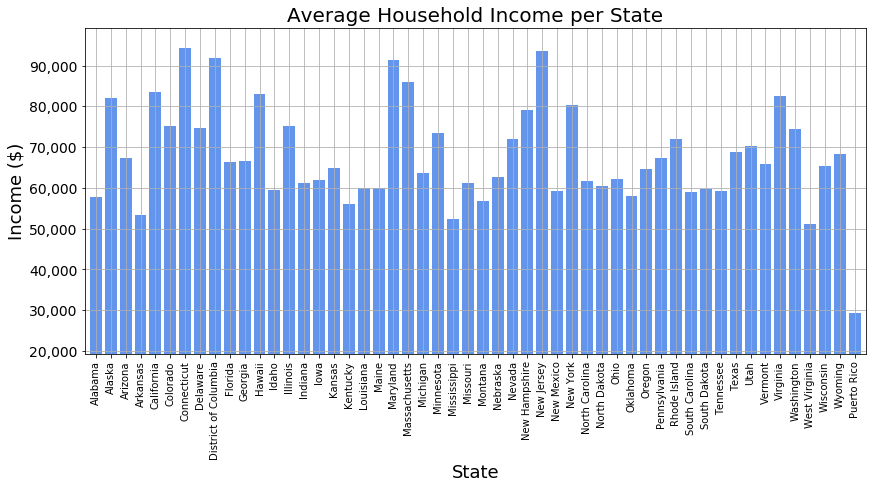

In [17]:
income_data = pd.read_csv("resources/income.csv")

# average household income per state bar graph
plt.figure(figsize = (14,6))
plt.bar(income_data["State"], income_data["Mean income"], color="cornflowerblue")
plt.title("Average Household Income per State", fontsize = 20)
tick_locations = [value for value in income_data["State"]]
plt.xticks(tick_locations, fontsize=10, rotation=90)
plt.yticks(fontsize = 14)
plt.ylim(min(income_data["Mean income"])-10000, max(income_data["Mean income"]+5000))
plt.xlabel("State", fontsize = 18)
plt.ylabel("Income ($)", fontsize = 18)
plt.grid()
plt.xlim(-0.75, len(income_data["State"])-0.25)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

#current fig size is 6.0 x 4.0
fig_size = plt.rcParams["figure.figsize"]
fig_size

fig_size[0] = 20
fig_size[1] = 10

plt.savefig("output/IncomePerState.png", edgecolor="black", frameon=True)

## Population / Age / Sex / Race

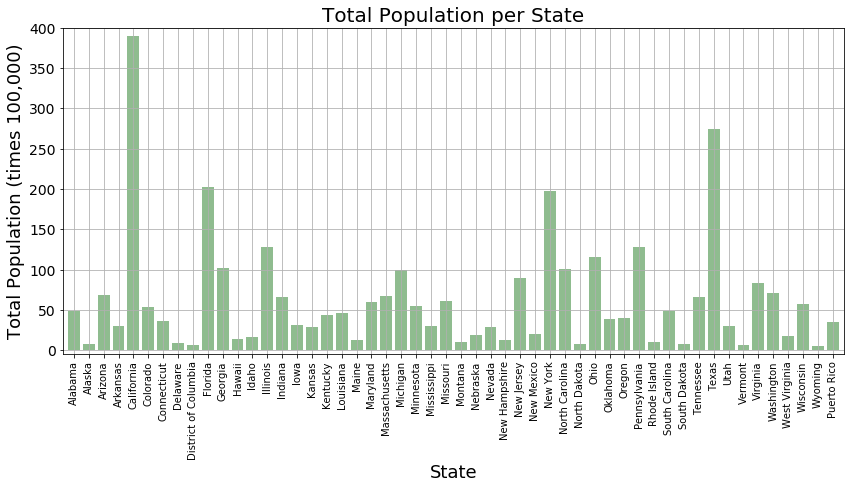

In [18]:
# dataframe for population/age/sex/race
demo_data = pd.read_csv("resources/sexagerace2013-2017.csv")
demo_data["Total population"] = pd.to_numeric(demo_data["Total population"])

# population per state bar graph
plt.figure(figsize = (14,6))
plt.bar(demo_data["State"], demo_data["Total population"]/100000, color="darkseagreen")
plt.ylim(min((demo_data["Total population"]/100000)-10), max((demo_data["Total population"])/100000)+10)
plt.xticks(rotation=90)
plt.yticks(fontsize = 14)
plt.grid()
plt.title("Total Population per State", fontsize = 20)
plt.xlim(-0.75, len(demo_data["State"])-0.25)
plt.xlabel("State", fontsize = 18)
plt.ylabel("Total Population (times 100,000)", fontsize = 18)

plt.savefig("output/PopulationPerState.png")

plt.show()

## Male / Female Ratio

<Figure size 1152x432 with 0 Axes>

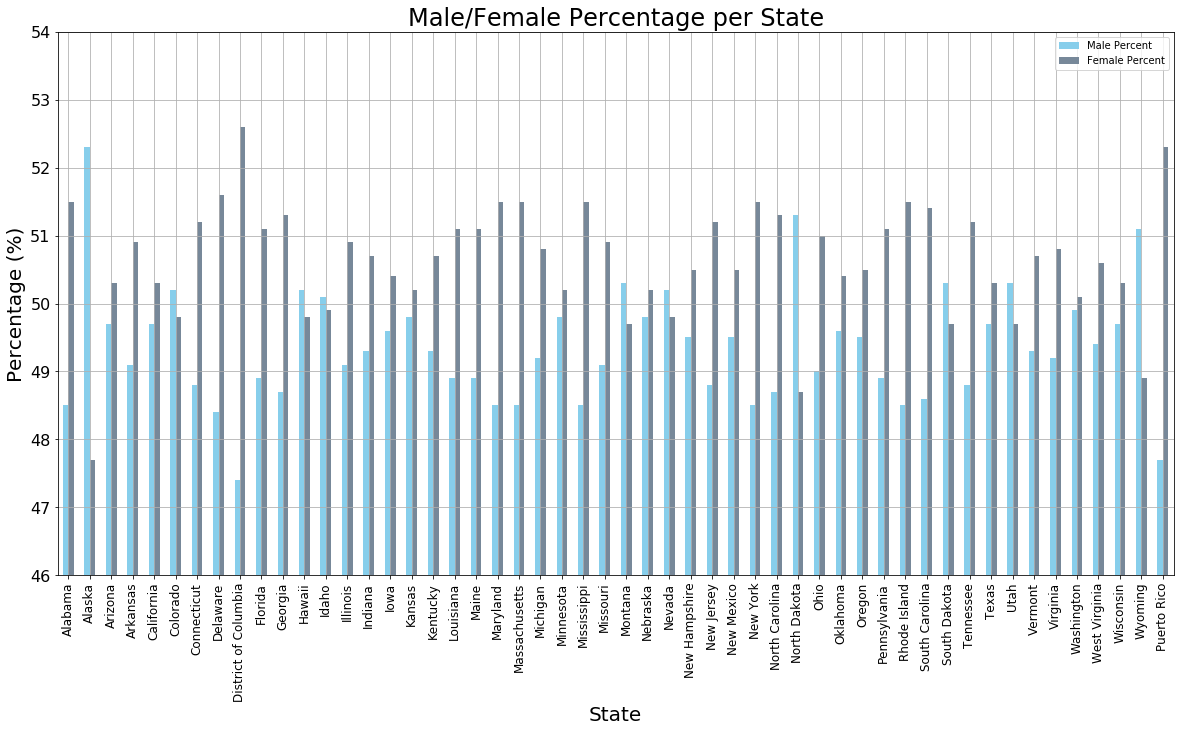

In [19]:
# male/female bar graph
plt.figure(figsize = (16,6))
demo_data.plot.bar(x = "State", y = ["Male Percent", "Female Percent"], rot = 90, color=["skyblue", "lightslategrey"])
plt.title("Male/Female Percentage per State", fontsize = 24)
plt.ylabel("Percentage (%)", fontsize = 20)
plt.xlabel("State", fontsize = 20)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 12)
plt.ylim(46, 54)
plt.grid()

plt.savefig("output/MaleFemalePerState.png")

plt.show()

## Race

<Figure size 1008x432 with 0 Axes>

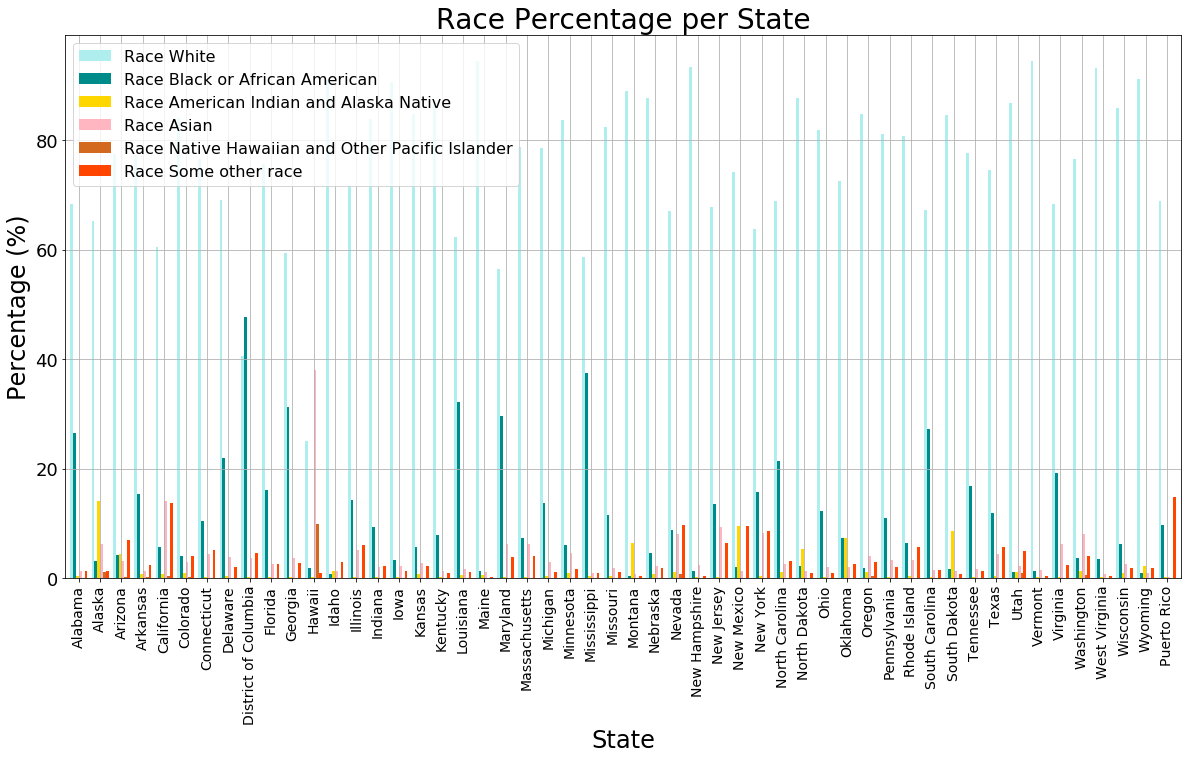

In [20]:
# race per state
color = ["paleturquoise", "darkcyan", "gold", "lightpink", "chocolate", "orangered"]

plt.figure(figsize = (14,6))
demo_data.plot.bar(x = "State", y = ["Race White", "Race Black or African American", "Race American Indian and Alaska Native", "Race Asian", "Race Native Hawaiian and Other Pacific Islander", "Race Some other race"], 
                   rot = 90,
                  width=.8,
                  fontsize=15,
                  color=color)
plt.title("Race Percentage per State", fontsize = 28)
plt.ylabel("Percentage (%)", fontsize = 24)
plt.xlabel("State", fontsize = 24)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)

fig_size = plt.rcParams["figure.figsize"]
fig_size

fig_size[0] = 30
fig_size[1] = 10

plt.grid()
#plt.tight_layout()

plt.savefig("output/RacePerState.png")

## Age

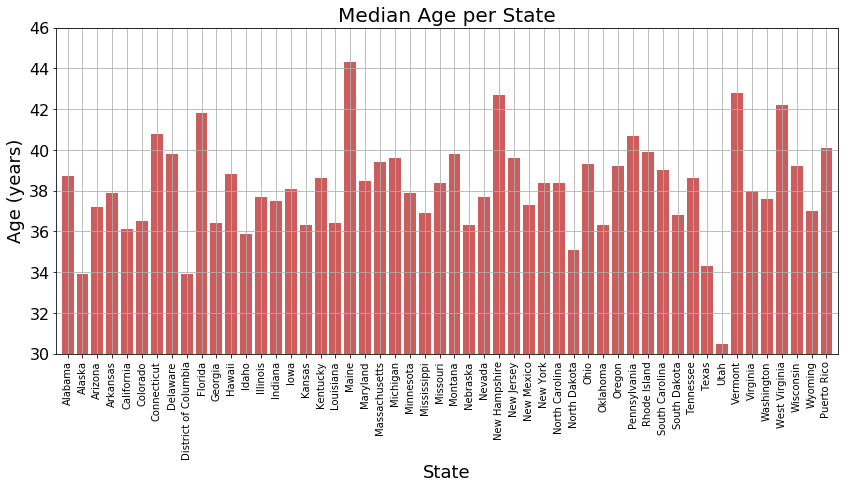

In [21]:
# median age per state
plt.figure(figsize = (14, 6))
plt.bar(demo_data["State"], demo_data["Median age (years)"], color="indianred")
plt.title("Median Age per State", fontsize=20)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize = 16)
plt.xlabel("State", fontsize=18)
plt.ylabel("Age (years)", fontsize=18)
plt.ylim(30, 46)
plt.xlim(-0.75, len(demo_data["State"])-0.25)

fig_size = plt.rcParams["figure.figsize"]
fig_size

fig_size[0] = 30
fig_size[1] = 20

plt.grid()

plt.savefig("output/AgePerState.png")

plt.show()

## Income per Region

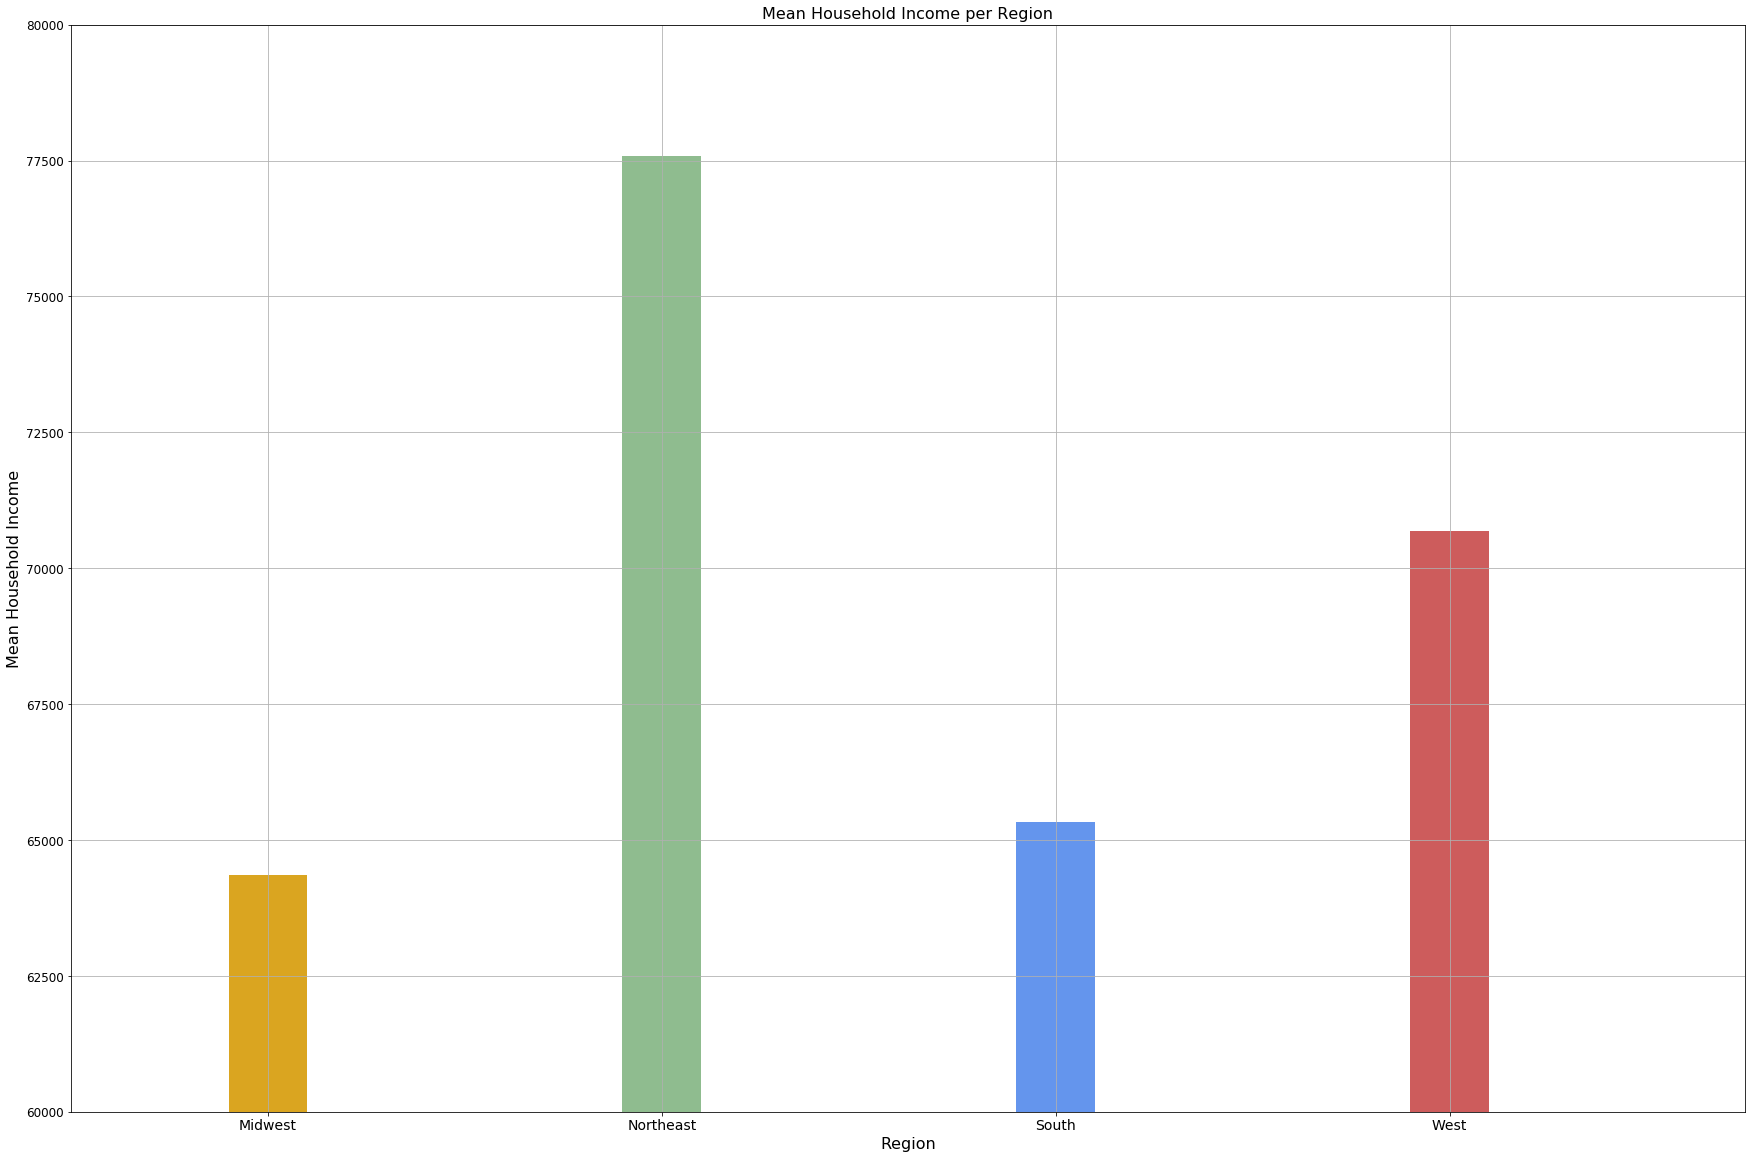

In [22]:
# dataframe to group states by region
regions_df = pd.read_csv("resources/state_census_codes.csv")
del regions_df["STFIPS"]

# merge regions dataframe and income dataframe
by_region = pd.merge(income_data, regions_df, on="State")

# mean income per region
region_income = by_region.groupby("Region").mean()['Mean income']
region_income
income_df = pd.DataFrame({"Region":["Midwest", "Northeast", "South", "West"],
             "Mean Income":[64353, 77588, 65333, 70687]})

# mean income per region bar graph
plt.bar(income_df["Region"], income_df["Mean Income"], width=.2, color=["goldenrod", "darkseagreen", "cornflowerblue", "indianred"])
plt.title("Mean Household Income per Region", fontsize=16)
plt.xlabel("Region", fontsize=16)
plt.ylabel("Mean Household Income", fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 12)
plt.xlim(-0.5, len(income_df["Region"])-0.25)
plt.ylim(60000, 80000)
plt.grid()

fig_size = plt.rcParams["figure.figsize"]
fig_size

fig_size[0] = 10
fig_size[1] = 5

plt.savefig("output/IncomePerRegion.png")

plt.show()

## Population per Region

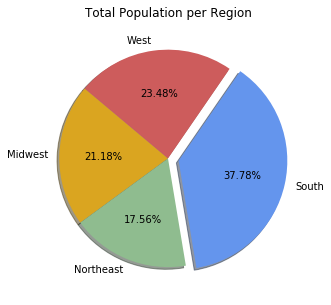

In [23]:
# merge region dataframe with demographics dataframe
demo_region = pd.merge(demo_data, regions_df, on="State")

# total population by region dataframe
region_pop = demo_region.groupby("Region").sum()["Total population"]
region_pop
pop_df = pd.DataFrame({"Region":["Midwest", "Northeast", "South", "West"],
        "Total Population":[67850273, 56275471, 121057103, 75238360]
})

# total population by region pie graph
sizes = pop_df["Total Population"]
labels = pop_df["Region"]
colors = ["goldenrod", "darkseagreen", "cornflowerblue", "indianred"]
explode = [0, 0, 0.1, 0]

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.2f%%", shadow=True, startangle=140)
plt.title("Total Population per Region")

plt.savefig("output/PopulationPerRegionPie.png")

plt.show()

## Race per Region

In [24]:
#race breakdown per region
#white
white_region = demo_region.groupby("Region").mean()["Race White"]
white_region_df = pd.DataFrame({"Region":["Midwest", "Northeast", "South", "West"],
    "White Percent":[83.68, 81.31, 69.34, 73.53]})
#black
black_region = demo_region.groupby("Region").mean()["Race Black or African American"]
black_region_df = pd.DataFrame({"Region":["Midwest", "Northeast", "South", "West"],
    "Black Percent":[7.63, 7.63, 22.00, 3.15]
})

#american indian/alaska native
native_region = demo_region.groupby("Region").mean()["Race American Indian and Alaska Native"]
native_region_df = pd.DataFrame({"Region":["Midwest", "Northeast", "South", "West"],
    "American Indian/Alaska Native Percent":[1.61, 0.32, 0.84, 3.53]
})

#asian
asian_region = demo_region.groupby("Region").mean()["Race Asian"]
asian_region_df = pd.DataFrame({"Region":["Midwest", "Northeast", "South", "West"],
    "Asian":[2.63, 4.47, 2.74, 7.54]
})

#Native Hawaiian/Other Pacific Islander
islander_region = demo_region.groupby("Region").mean()["Race Native Hawaiian and Other Pacific Islander"]
islander_region_df = pd.DataFrame({"Region":["Midwest", "Northeast", "South", "West"],
    "Native Hawaiian/Other Pacific Islander":[0.03, 0.01, 0.06, 1.24]
})

#other race
otherrace_region = demo_region.groupby("Region").mean()["Race Some other race"]
otherrace_region_df = pd.DataFrame({"Region":["Midwest", "Northeast", "South", "West"],
    "Other Race":[1.85, 3.68, 2.35, 5.16]
})

#merge all races into one dataframe
merge1 = pd.merge(white_region_df, black_region_df, on="Region")
merge2 = pd.merge(merge1, native_region_df, on="Region")
merge3 = pd.merge(merge2, asian_region_df, on="Region")
merge4 = pd.merge(merge3, islander_region_df, on="Region")
races_region = pd.merge(merge4, otherrace_region_df, on="Region")
races_region = races_region.rename(columns={"White Percent":"White", "Black Percent":"Black", 
    "American Indian/Alaska Native Percent":"Native", "Native Hawaiian/Other Pacific Islander":"Islander", "Other Race":"Other"})

#separate race dataframe into separate races to be able to put in graph
#midwest
mw_races = pd.DataFrame({"Race":["White", "Black", "Native", "Asian", "Islander", "Other"],
    "Percentage":[83.68, 7.63, 1.61, 2.63, 0.03, 1.85]})

#northeast
ne_races = pd.DataFrame({"Race":["White", "Black", "Native", "Asian", "Islander", "Other"],
    "Percentage":[81.31, 7.63, 0.32, 4.47, 0.01, 3.68]})

#south
s_races = pd.DataFrame({"Race":["White", "Black", "Native", "Asian", "Islander", "Other"],
    "Percentage":[69.34, 22.00, 0.84, 2.74, 0.06, 2.34]})

#west
w_races = pd.DataFrame({"Race":["White", "Black", "Native", "Asian", "Islander", "Other"],
    "Percentage":[73.53, 3.15, 3.53, 7.54, 1.24, 5.16]})

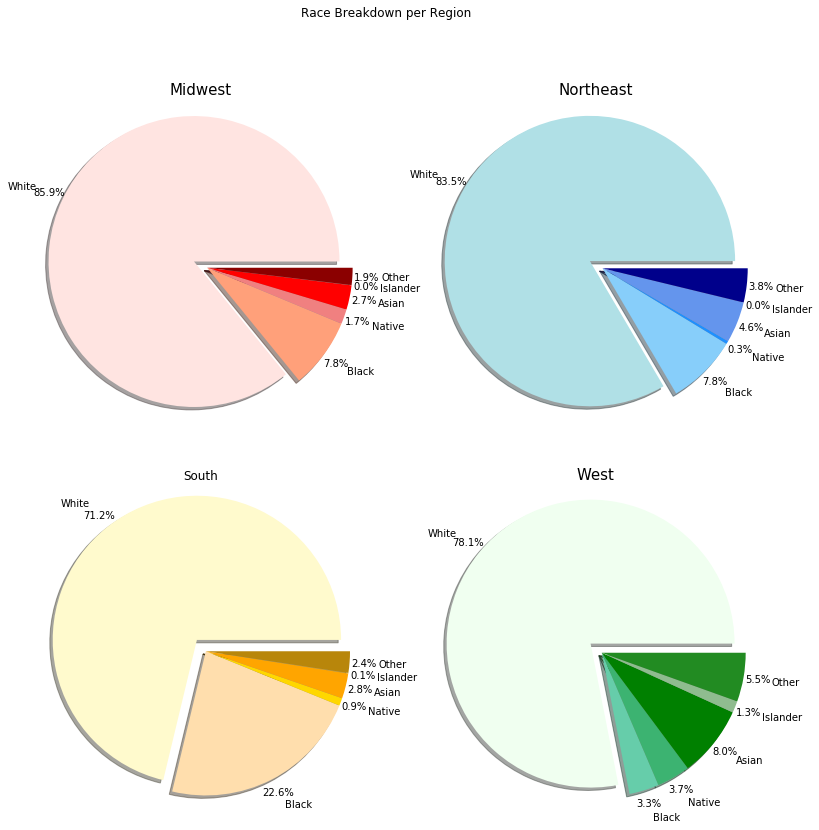

In [25]:
#race per region pie chart
explode = [0.1, 0, 0, 0, 0, 0]

plt.figure(figsize = (13, 13))

mw_colors = ["mistyrose", "lightsalmon", "lightcoral", "red", "indianred", "darkred"]
ne_colors = ["powderblue", "lightskyblue", "dodgerblue", "cornflowerblue", "slateblue", "darkblue"]
s_colors = ["lemonchiffon", "navajowhite", "gold", "orange", "goldenrod", "darkgoldenrod"]
w_colors = ["honeydew", "mediumaquamarine", "mediumseagreen", "g", "darkseagreen", "forestgreen"]

plt.subplot(221)
plt.pie(mw_races["Percentage"], colors=mw_colors, explode=explode, labels=mw_races["Race"], autopct="%1.1f%%", shadow=True,
       pctdistance=1.1, labeldistance=1.2)
plt.axis("equal")
plt.title("Midwest", fontsize=15)

plt.subplot(222)
plt.pie(ne_races["Percentage"], colors=ne_colors, explode=explode, labels=mw_races["Race"], autopct="%1.1f%%", shadow=True,
       pctdistance=1.1, labeldistance=1.2)
plt.axis("equal")
plt.title("Northeast", fontsize=15)

plt.subplot(223)
plt.pie(s_races["Percentage"], colors=s_colors, explode=explode, labels=mw_races["Race"], autopct="%1.1f%%", shadow=True,
       pctdistance=1.1, labeldistance=1.2)
plt.axis("equal")
plt.title("South")

plt.subplot(224)
plt.pie(w_races["Percentage"], colors=w_colors, explode=explode, labels=mw_races["Race"], autopct="%1.1f%%", shadow=True,
       pctdistance=1.1, labeldistance=1.2)
plt.axis("equal")
plt.title("West", fontsize=15)

plt.suptitle("Race Breakdown per Region")

fig_size = plt.rcParams["figure.figsize"]
fig_size

fig_size[0] = 20
fig_size[1] = 15
fig_size = plt.rcParams["figure.figsize"]

plt.savefig("output/RacePerRegion.png")

plt.show()

# Statistical Analysis

## Suicide Rates and Centers Scatterplot Regression

Null hypothesis: There is no relationship between the number of centers per state and the state's suicide rate.

Alternative hypothesis: There is some relationship between the number of centers per state and the state's suicide rate.

We perform a linear regression on the number of centers per state compared to the suicide rate per state.

In [26]:
slope, intercept, rval, pval, stderr = linregress(income_region_suicide['Per Capita'], income_region_suicide['Crude Rate'])
print(f'slope: {slope}, intercept: {intercept}, rval: {rval}, pval: {pval}, stderr: {stderr}, r-squared: {rval ** 2}')

slope: -0.01418554741743859, intercept: 19.636044262463678, rval: -0.454217030543642, pval: 0.0008137829537236146, stderr: 0.003974744793871774, r-squared: 0.2063131108358838


Because the p-value of 0.0008 obtained from the regression is less than the threshold of 0.05, we reject the null hypothesis that there is no relationship between the number of centers per state and the state's suicide rate.

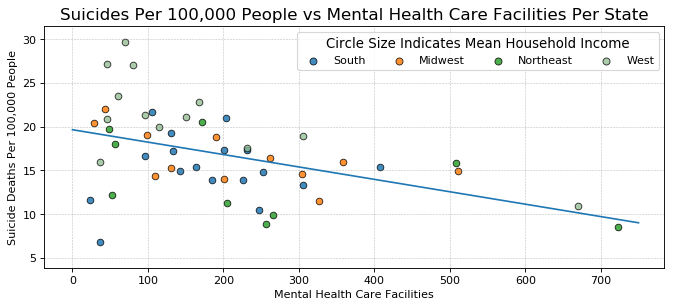

In [27]:
plt.figure(figsize=(10, 4), dpi=80)

plt.scatter(region_south["Per Capita"], region_south["Crude Rate"], marker="o", alpha=.85, linewidth=.75, edgecolors="black", label="South")
plt.scatter(region_midwest["Per Capita"], region_midwest["Crude Rate"], marker="o", alpha=.85, linewidth=.75, edgecolors="black", label="Midwest")
plt.scatter(region_northeast["Per Capita"], region_northeast["Crude Rate"], marker="o", alpha=.85, linewidth=.75, edgecolors="black", label="Northeast")
plt.scatter(region_west["Per Capita"], region_west["Crude Rate"], marker="o", color="darkseagreen", alpha=.75, linewidth=.85, edgecolors="black", label="West")

reg_x = arange(0, 750, 0.1)
reg_y = reg_x * slope + intercept

plt.plot(reg_x, reg_y)

# Size the plot
plot_margin = -2

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 + .25,
          x1 - 3.25,
          y0 - 1.75,
          y1 + .5))

# Label the plot
plt.title("Suicides Per 100,000 People vs Mental Health Care Facilities Per State", horizontalalignment="center", fontsize=15)
plt.xlabel("Mental Health Care Facilities")
plt.ylabel("Suicide Deaths Per 100,000 People")

# Format the grid
plt.grid(color='grey', linestyle='--', linewidth=.5, alpha=.5)
# plt.legend(loc=(.8, .1))
lgnd = plt.legend(loc="best", scatterpoints=1, fontsize=10, ncol=4, title="Circle Size Indicates Mean Household Income", title_fontsize=12)
lgnd.legendHandles[0]._sizes = [40]
lgnd.legendHandles[1]._sizes = [40]
lgnd.legendHandles[2]._sizes = [40]
lgnd.legendHandles[3]._sizes = [40]
# Show the plot
plt.savefig('output/scatter_regression.png')
plt.show()

Possible presence of heteroskedasticity in the above data, as the points do not appear to have uniform residuals. Using Levene's test to determine if this is true.

Null hypothesis: There is no heteroskedasticity in the data.

In [28]:
w, p = levene(income_region_suicide['Per Capita'], income_region_suicide['Crude Rate'])
print(f'w: {w}, p-value: {p}')

w: 47.16258364252435, p-value: 5.616617315507742e-10


Because the p-value of 5.617 x 10^-10 is less than the threshold of 0.05, we reject the null hypothesis that there is no heteroskedasticity in the data. An analysis resistant to heteroskedasticity would be preferred.